# TGFB3
Pathogenic variants in TGFB3 are associated with both 
[Arrhythmogenic right ventricular dysplasia 1 (OMIM:107970)](https://omim.org/entry/107970)	and
[Loeys-Dietz syndrome 5	(OMIM:615582)](https://omim.org/entry/615582).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### TGFB3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFB3.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'TGFB3'
mane_tx_id = 'NM_003239.5'
mane_protein_id = 'NP_003230.1' # transforming growth factor beta-3 proprotein isoform 1 preproprotein
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 75/75 [00:00<00:00, 86.26 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
28,Aortic root aneurysm
23,Tall stature
23,Hypertelorism
16,Arachnodactyly
16,Retrognathia
15,Scoliosis
12,Mitral valve prolapse
12,Bifid uvula
11,Long face
10,Cleft palate


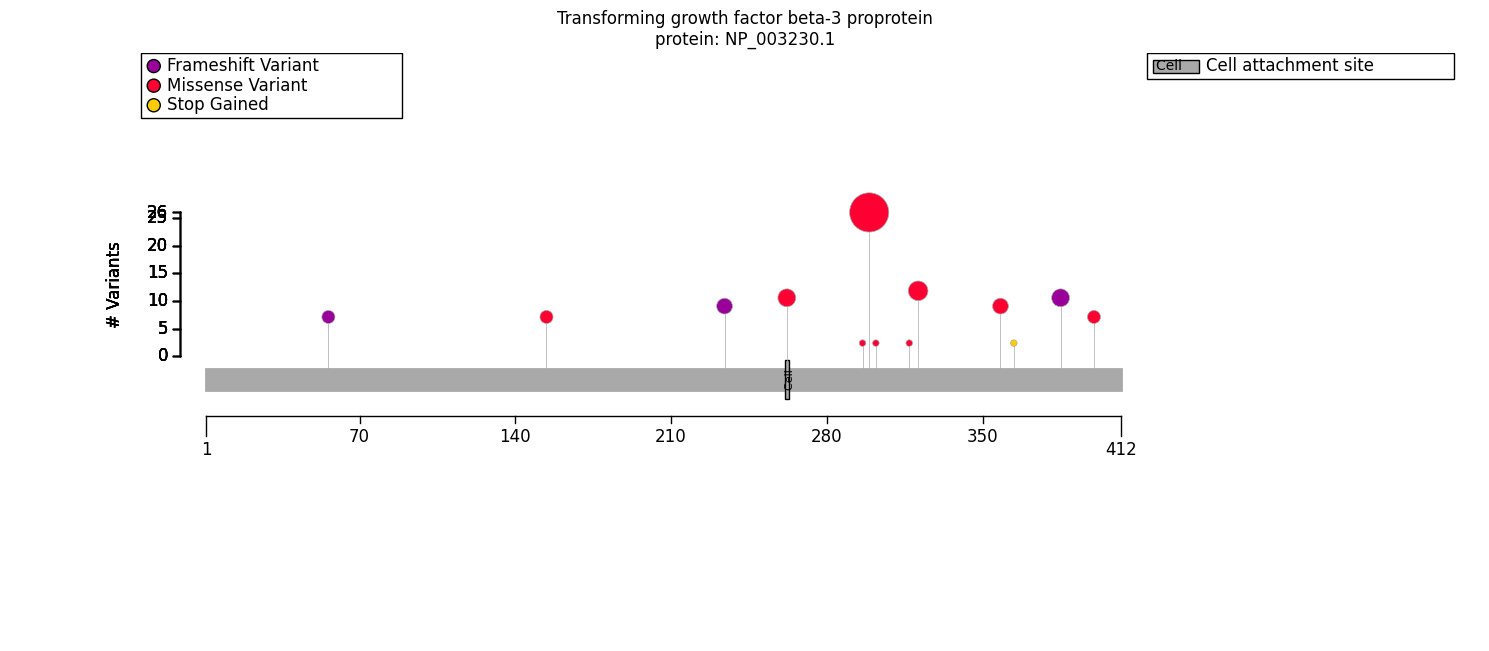

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

tgfb3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
tgfb3_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
4,Cell attachment site,Motif,262 - 263,p.Asp263His


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier

asp263his = variant_key(key="14_75963455_75963455_C_G") # c.787G>C; p.Asp263His

asp263his_clf = monoallelic_classifier(
    a_predicate=asp263his,
    b_predicate=~asp263his,
    a_label="Asp263His",
    b_label="Other"
)

asp263his_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=asp263his_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(asp263his_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,1
Skipping term because one genotype had zero observations,39
"Skipping ""general"" level terms",60
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),141


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=asp263his_result)

Allele group,Asp263His,Other,Corrected p values,p values
Short stature [HP:0004322],1/4 (25%),0/39 (0%),1.0,0.093023
Dolichocephaly [HP:0000268],1/1 (100%),7/33 (21%),1.0,0.235294
Aortic root aneurysm [HP:0002616],3/4 (75%),25/54 (46%),1.0,0.344498
Retrognathia [HP:0000278],1/1 (100%),15/40 (38%),1.0,0.390244
Ascending aortic dissection [HP:0004933],1/4 (25%),5/39 (13%),1.0,0.464833
Mitral valve prolapse [HP:0001634],0/4 (0%),12/54 (22%),1.0,0.570651
Scoliosis [HP:0002650],0/4 (0%),15/71 (21%),1.0,0.577687
Motor delay [HP:0001270],0/4 (0%),1/39 (3%),1.0,1.000000
Aortic rupture [HP:0031649],0/4 (0%),1/39 (3%),1.0,1.000000
Abdominal aortic aneurysm [HP:0005112],0/4 (0%),2/69 (3%),1.0,1.000000


In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Varicose veins [HP:0002619],3/22 (14%),6/12 (50%),0.735484,0.040313
Dermal translucency [HP:0010648],8/31 (26%),1/22 (5%),0.735484,0.063955
Carotid artery tortuosity [HP:0005302],0/22 (0%),2/8 (25%),0.735484,0.064368
Vertebral artery tortuosity [HP:0033981],0/22 (0%),2/8 (25%),0.735484,0.064368
Dental crowding [HP:0000678],0/23 (0%),2/9 (22%),0.735484,0.072581
Iliac artery aneurysm [HP:4000067],0/22 (0%),2/9 (22%),0.735484,0.077419
Aortic root aneurysm [HP:0002616],15/38 (39%),13/20 (65%),0.792324,0.097303
Cleft palate [HP:0000175],6/33 (18%),4/11 (36%),1.000000,0.237179
Abdominal aortic dissection [HP:0033311],0/22 (0%),1/8 (12%),1.000000,0.266667
Dilated cardiomyopathy [HP:0001644],0/22 (0%),1/8 (12%),1.000000,0.266667


In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Dolichocephaly [HP:0000268],0/14 (0%),8/20 (40%),0.565175,0.010884
Aortic root aneurysm [HP:0002616],8/26 (31%),20/32 (62%),0.565175,0.019831
Dermal translucency [HP:0010648],7/24 (29%),2/29 (7%),1.000000,0.062321
Camptodactyly [HP:0012385],3/16 (19%),0/18 (0%),1.000000,0.093583
Tall stature [HP:0000098],7/25 (28%),16/30 (53%),1.000000,0.098719
Carotid artery tortuosity [HP:0005302],2/13 (15%),0/17 (0%),1.000000,0.179310
Vertebral artery tortuosity [HP:0033981],2/13 (15%),0/17 (0%),1.000000,0.179310
Proptosis [HP:0000520],2/14 (14%),0/18 (0%),1.000000,0.183468
Ascending aortic dissection [HP:0004933],1/20 (5%),5/23 (22%),1.000000,0.191797
Mitral valve prolapse [HP:0001634],3/26 (12%),9/32 (28%),1.000000,0.192917


# Summary
We found no evidence for genotype-phenotype correlations.

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=asp263his_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant correlations identified."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,57,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Asp263His,Other,18,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,57,0


In [14]:
summarizer.process_latex(report=report, protein_fig=tgfb3_fig)

Figure saved to ../../supplement/img/TGFB3_protein_diagram-draft.pdf
Output to ../../supplement/tex/TGFB3_summary_draft.tex
